In [2]:
!pip install pydrake
!pip install drake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 MB 2.1 MB/s eta 0:00:00m eta 0:00:010:00:02m


In [1]:
from pydrake.symbolic import Variable 
from pydrake.systems.primitives import SymbolicVectorSystem 

# Define a new symbolic Variable 
x = Variable("x")

continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[-x+x**3], output=[x])

## Implemented vector system: 

$$x[n+1] = x^{3}[n]$$
$$y[n] = x[n]$$

In [2]:
from pydrake.systems.framework import LeafSystem

# Define the system.
class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    # xdot(t) = -x(t) + x^3(t)
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

# Instantiate the System
continuous_system = SimpleContinuousTimeSystem()


# Define the system.
class SimpleDiscreteTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

# Instantiate the System
discrete_system = SimpleDiscreteTimeSystem()

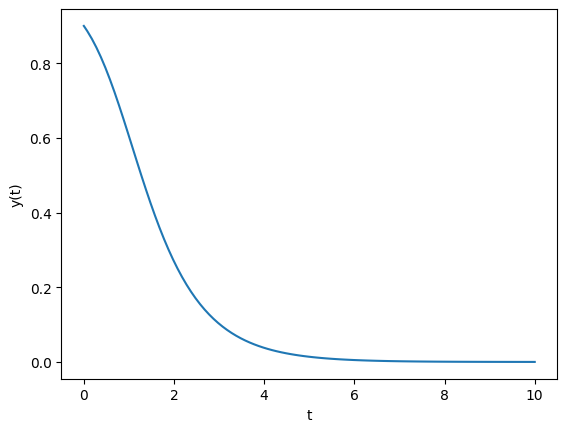

In [3]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator 
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create a simple block diagram containing our system 
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0)
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the result 
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)'); 

Text(0, 0.5, 'y[n]')

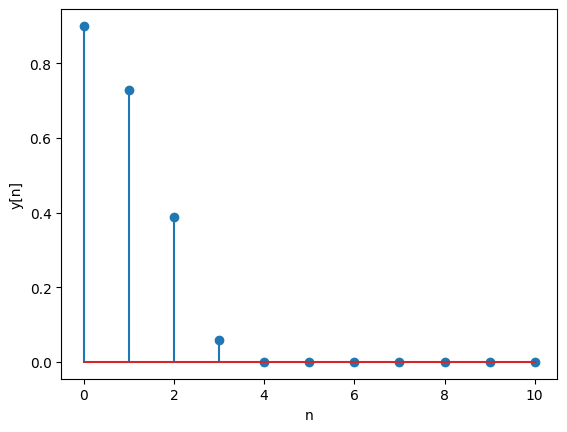

In [4]:
# Create a simple block diagram containing our system 
builder = DiagramBuilder()
system = builder.AddSystem(SimpleDiscreteTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Create the simulator
simulator = Simulator(diagram)

# Set the initial conditions, x(0)
state = simulator.get_mutable_context().get_mutable_discrete_state_vector()
state.SetFromVector([0.9])

# Simulate for 10 seconds
simulator.AdvanceTo(10)

# Plot the results 
log = logger.FindLog(simulator.get_context())
plt.figure()
plt.stem(log.sample_times(), log.data().transpose())
plt.xlabel('n')
plt.ylabel('y[n]')

`Context` captures all of the (potentially) dynamic information that a `System` requires to implement its core methods: this includes the time, the state, any inputs, and any system parameters. The `Context` of a `System` is everything you need to know for simulation (or control desing, ... and given a `Context` all methods called on a `System` should be completely deterministic/repeatable. 

## Combinations of Systems: Diagram and DiagramBuilder

The real modelling power of Drake comes from combining many smaller systems together into more complex systems. The concept is very simple: we use the `DiagramBuilder` class to `AddSystem()` and to `Connnect()` input ports to output ports or to expose them as inputs/output fo the diagrama. Then we call `Build()` to generate teh new `Diagram` instance, which is just another `System` in the framework, and can be simulated or analyied using the entire suite of tools. In the example below, we connected three subsystems (a plant, a controller, and a logger), and expose the input fo the controller as an input tot he `Diagram` being constructed: 

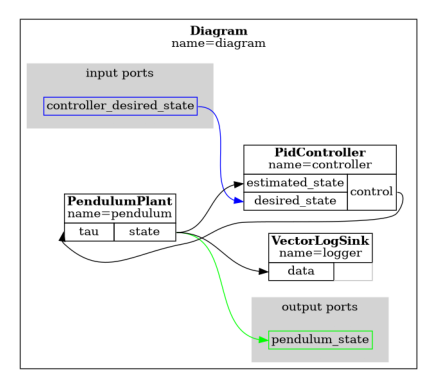

In [5]:
import matplotlib.pyplot as plt 
import numpy as np 
import pydot
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator 
from pydrake.systems.controllers import PidController
from pydrake.systems.drawing import plot_system_graphviz
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# First add the pendulum 
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller
controller = builder.AddNamedSystem("controller", PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant 
builder.Connect(pendulum.get_state_output_port(), 
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram 
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an ouput from the diagram 
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum 
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram
plot_system_graphviz(diagram)

Text(0.5, 1.0, 'PID Control of the Pendulum')

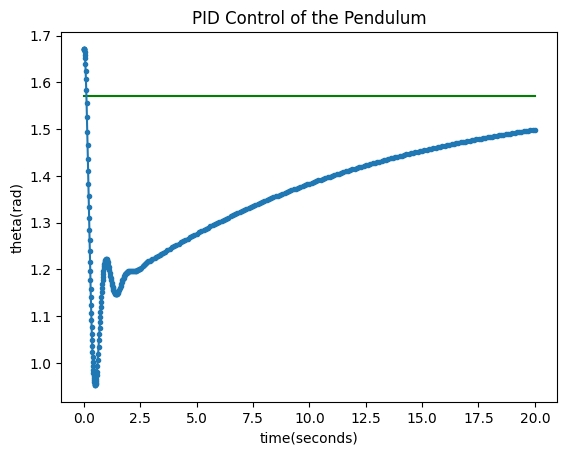

In [6]:
# Set up a simulator to run this diagram 
simulator = Simulator(diagram) 
context = simulator.get_mutable_context() 

# We'll try to regulate the pendulum to a particular angle. 
desired_angle = np.pi/2

# First we extract the subsystem context for the pendulum 
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context) 
# Then we can set the pendulum state, whic is theta, thetadot) 
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2]) 

# The diagram has sa signle input port (port index 0) , which is the desired state 
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger 
logger.FindMutableLog(context).Clear()

# Simulate for 10 seconds 
simulator.AdvanceTo(20); 

# Plot the results 
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta
# Draw a line for the desired angle. 
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g')
plt.plot(t, log.data()[0, :], '.-')
plt.xlabel('time(seconds)')
plt.ylabel('theta(rad)')
plt.title('PID Control of the Pendulum')

### Planar Quadrotor

In [3]:
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import DiagramBuilder, LinearQuadraticRegulator, Simulator

#from underactuated import runnning_as_notebook
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer


#### Install underactuated by MIT 

In [19]:
!pip install --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly underactuated

Looking in indexes: https://pypi.org/simple, https://drake-packages.csail.mit.edu/whl/nightly
  Using cached underactuated-2023.10.5-py3-none-any.whl.metadata (1.3 kB)
INFO: pip is looking at multiple versions of underactuated to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.8/720.8 kB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5007 sha256=c7c74d85f81a10a949a0cb89988f4ff5bbe3e02e98a10a2d34f330dbcc516f0f
  Stored in directory: /home/zozan/.cache/pip/wheels/38/05/4e/161d1463ca145ec1023bd4e5e1f31cbf9239aa8f39a2a2b643
Successfully built timeout-decorator


In [16]:
def planar_quadrotor_example(): 
    def QuadrotorLQR(plant): 
        context = plant.CreateDefaultContext()
        context.SetContinuousState(np.zeros([6, 1]))
        plant.get_input_port(0).FixValue(context, plant.mass * plant.gravity/2.0 * np.array([1, 1]))
        Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2.0 / np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]]) 

        return LinearQuadraticRegulator(plant, context, Q, R)

    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())
    
    controller = builder.AddSystem(QuadrotorLQR(plant))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Setup visualization 
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram 
    simulator = Simulator(diagram) 
    context = simulator.get_mutable_context()

    # Simulate 
    duration = 5.0
    visualizer.start_recording()
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            np.random.randn(
                6,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))
    


In [ ]:
planar_quadrotor_example()    

done.
generating animation...


In [ ]:
import numpy as np 
from pydrake.all import(
    DiagramBuilder, 
    LinearQuadraticRegulator, 
    MeshcatVisualizer, 